In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import warnings

warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot

plt.style.use('ggplot')
%matplotlib inline

### Motivação
A inspiração deste trabalho surgiu após refletir sobre algumas métricas orçamentárias no meu trabalho, onde diariamente me deparo com metas desconexas, que além de desestimular toda a equipe, nos gera uma baita canseira mental, principalmente quando não estão nem perto de serem atingidas.
Pensando nisso, resolvi aplicar técnicas estatísticas para modelar as vendas, mesmo em pequenos negócios. Por mais que seja de difícil compreensão para muitos, este processo pode auxiliar o desenvolvimento do forecast e por consequência facilitar a tomada de decisões, tornando-as cada vez mais lógicas e com suporte científico.


### Objetivo

* Estudar as vendas diárias de uma empresa com 3 unidades diferentes.
* Entender como o comportamento dos dados pode ser vital, para gerar um modelo que consiga “prever” os números, dado um intervalo de confiança
* E como um processo orçamentário de qualidade, pode servir como “baliza” para traçar estratégias mais assertivas.  

### DATASET:
    * O Dataset é composto por 3 unidades, que não estão concentradas geograficamente e seus dados dependem apenas do tempo.
    * Para criarmos uma imagem mais sólida do business, vamos supor uma megaloja de brinquedos (meu filho deu o exemplo).
    * O Dataset é composto por 323 observações. De 01/01/2018 até 19/11/2018.
    * Vamos tentar prever as vendas até o final do ano.

In [5]:
# Vamos ler o excel e usar a primeira coluna como index.

vendas = pd.read_excel('vendas.xlsx',
                        index_col=0)
vendas.head()

,UNIDADE 1,UNIDADE 2,UNIDADE 3
DATE,,,
2018-01-01,30133.690437,16811.969088,12007.010284
2018-01-02,22942.089204,14554.931264,14404.102961
2018-01-03,18799.724523,12071.650985,12233.279673
2018-01-04,25037.579141,13876.203899,12362.534142
2018-01-05,27413.151851,21498.419939,11689.193502


#### Vamos ver as vendas em totais mensais.

In [8]:
vendas_m = vendas.resample('M').sum()
display(round(vendas_m,2))

,UNIDADE 1,UNIDADE 2,UNIDADE 3
DATE,,,
2018-01-31,640088.57,442858.81,389605.69
2018-02-28,523978.01,422173.81,320728.31
2018-03-31,532144.02,423929.88,379769.51
2018-04-30,678813.55,498956.19,394152.06
2018-05-31,677066.73,490445.16,397217.11
2018-06-30,660067.75,460193.31,382969.22
2018-07-31,651486.70,453626.90,389562.57
2018-08-31,703840.52,497679.53,393467.95
2018-09-30,682149.69,555042.77,406439.26


## Primeira análise - Análise visual dos dados diários.
* Objetivo principal é detectar visualmente estacionariedade, tendências e sazonalidades

Como observado, temos indícios que as séries são estacionárias. Estacionariedade é uma característica das séries temporais que necessariamente deve estar presente para o modelo objetivo do trabalho. Há maneiras de estacionarizar uma série de dados, mas não se fez necessário neste sample de dados.
 * Estacionariedade = Média, variância e estrutura de correlação não são função do tempo.

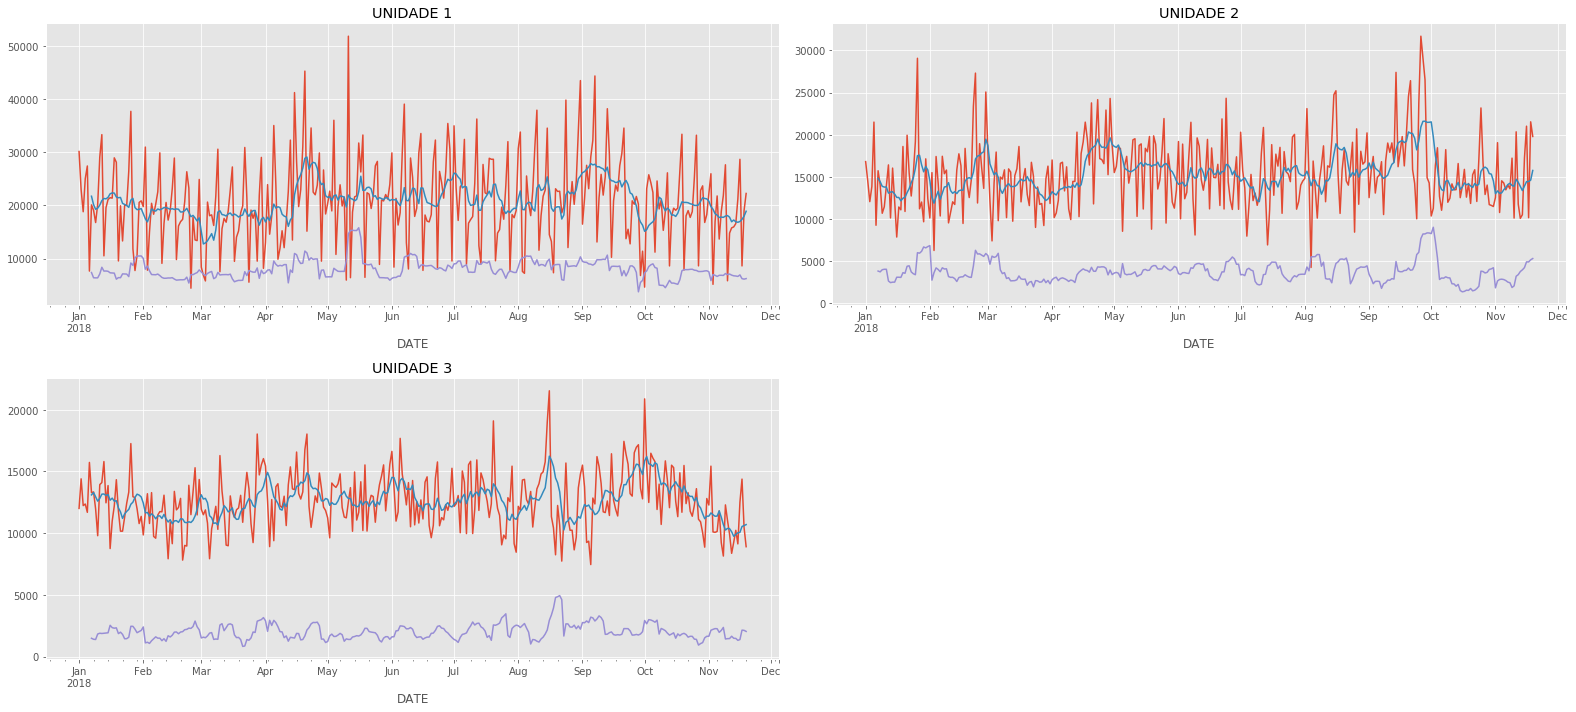

In [9]:
plt.figure(1, figsize=(22, 10))
for i in range(3):
    plt.subplot(2,2,i+1)
    vendas[vendas.columns[i]].plot()
    mov_avg = vendas[vendas.columns[i]].rolling(window=7).mean()
    mov_std = vendas[vendas.columns[i]].rolling(window=7).std()
    mov_avg.plot()
    mov_std.plot()
    
    plt.title(vendas.columns[i])

plt.tight_layout()

## Segunda análise - Teste matemático para provar a estacionariedade.

* Utilizando o teste aumentado de Dick Fuller podemos "detectar" a estacionariedade dos dados.
* Se p-valor <= 0.05 há estacionariedade. 

In [10]:
lista = ['Test Statistic', 'p-value',
        'Number of lags used', 'Observations']
colunas = vendas.columns
df = pd.DataFrame(index=lista, columns=colunas)
for i in range(3):
    result = adfuller(vendas[vendas.columns[i]])
    aux = result[:4]
    df[vendas.columns[i]] = aux
df

,UNIDADE 1,UNIDADE 2,UNIDADE 3
Test Statistic,-2.744892,-3.863715,-3.757033
p-value,0.066587,0.002319,0.003379
Number of lags used,13.000000,17.000000,9.000000
Observations,309.000000,305.000000,313.000000


### Estacionarizando uma série.

Como nossas vendas da Unidade 1 não se provou estacionária, podemos manipulá-la como o log natural dos valores observados.
Realizando novamente o teste temos a tão desejada estacionariedade.

Lembrando que agora temos um padrão diferente que deve ser convertido no final... 

In [11]:
vendas_log = np.log(vendas)
for i in range(3):
    result = adfuller(vendas_log[vendas_log.columns[i]])
    aux = result[:4]
    df[vendas.columns[i]] = aux
df

,UNIDADE 1,UNIDADE 2,UNIDADE 3
Test Statistic,-3.037658,-3.867341,-3.640278
p-value,0.031524,0.002289,0.005036
Number of lags used,14.000000,14.000000,9.000000
Observations,308.000000,308.000000,313.000000


## Terceira análise - Decomposição das séries de vendas diárias
Detectar tendências e sazonalidades dos dados.
Cada plot é composto por 4 mini gráficos:
   * 1º- Os dados diários observados.
   * 2º- Linha de tendência dos dados.
   * 3º- Sazonalidade percebida
   * 4º- Resultados que não podem ser explicados pela tendência ou sazonalidade.

'UNIDADE 1'

'UNIDADE 2'

'UNIDADE 3'

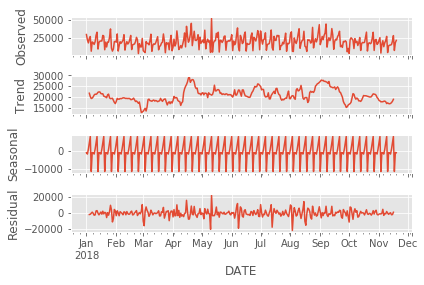

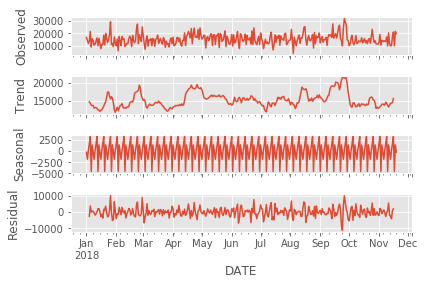

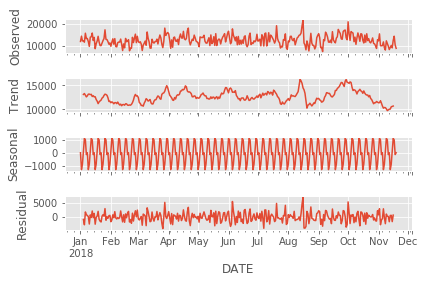

In [7]:
for i in range(3):
    decoposition = seasonal_decompose(vendas[vendas.columns[i]], model ='additive')
    decoposition.plot()
    display(vendas.columns[i])
    
plt.tight_layout()

## Quarta análise - Orbservando a autocorrelação e autocorrelação parcial


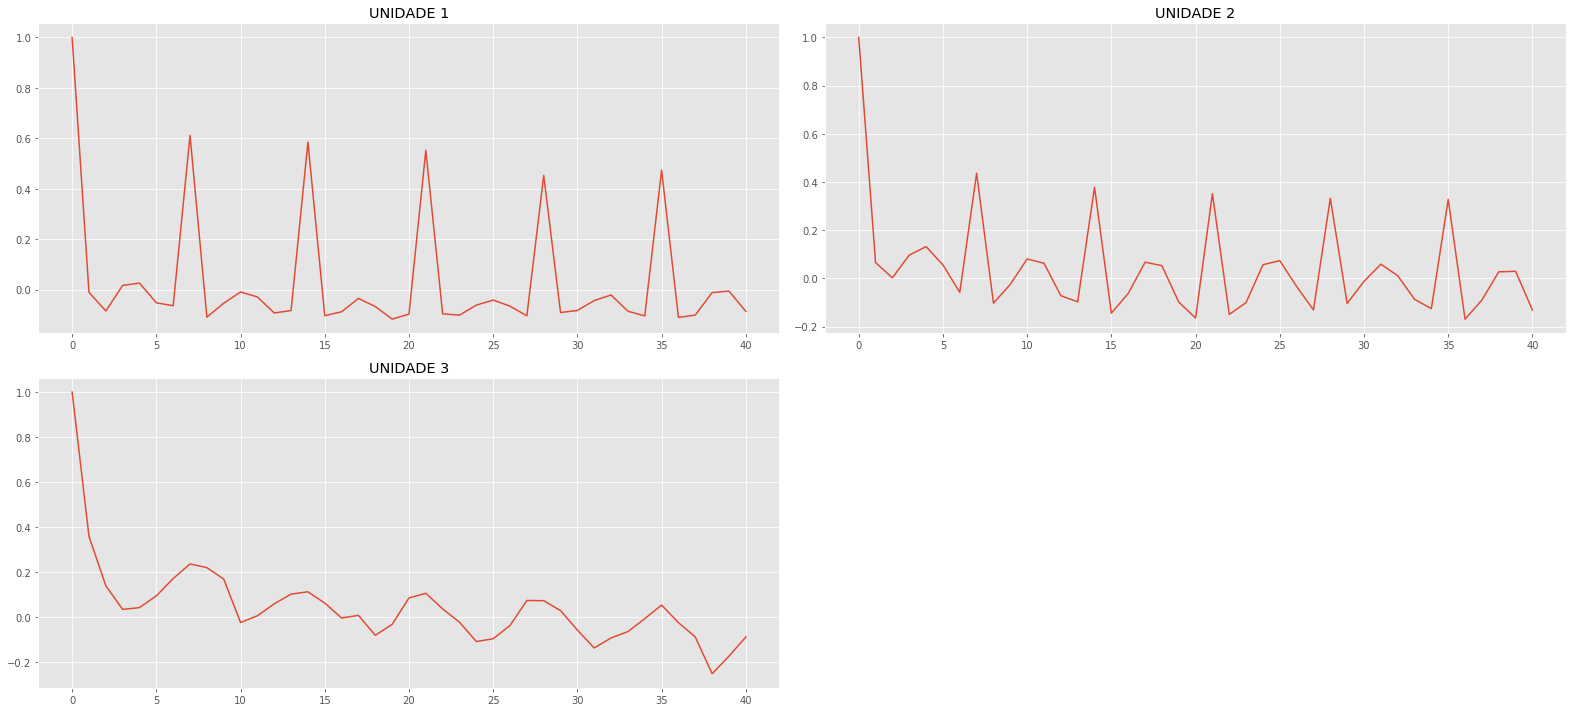

In [8]:
plt.figure(1, figsize=(22, 10))
for i in range(3):
    plt.subplot(2,2,i+1)
    acf_x = acf(vendas_log[vendas_log.columns[i]])
    plt.plot(acf_x)
    plt.title(vendas_log.columns[i])

plt.tight_layout()

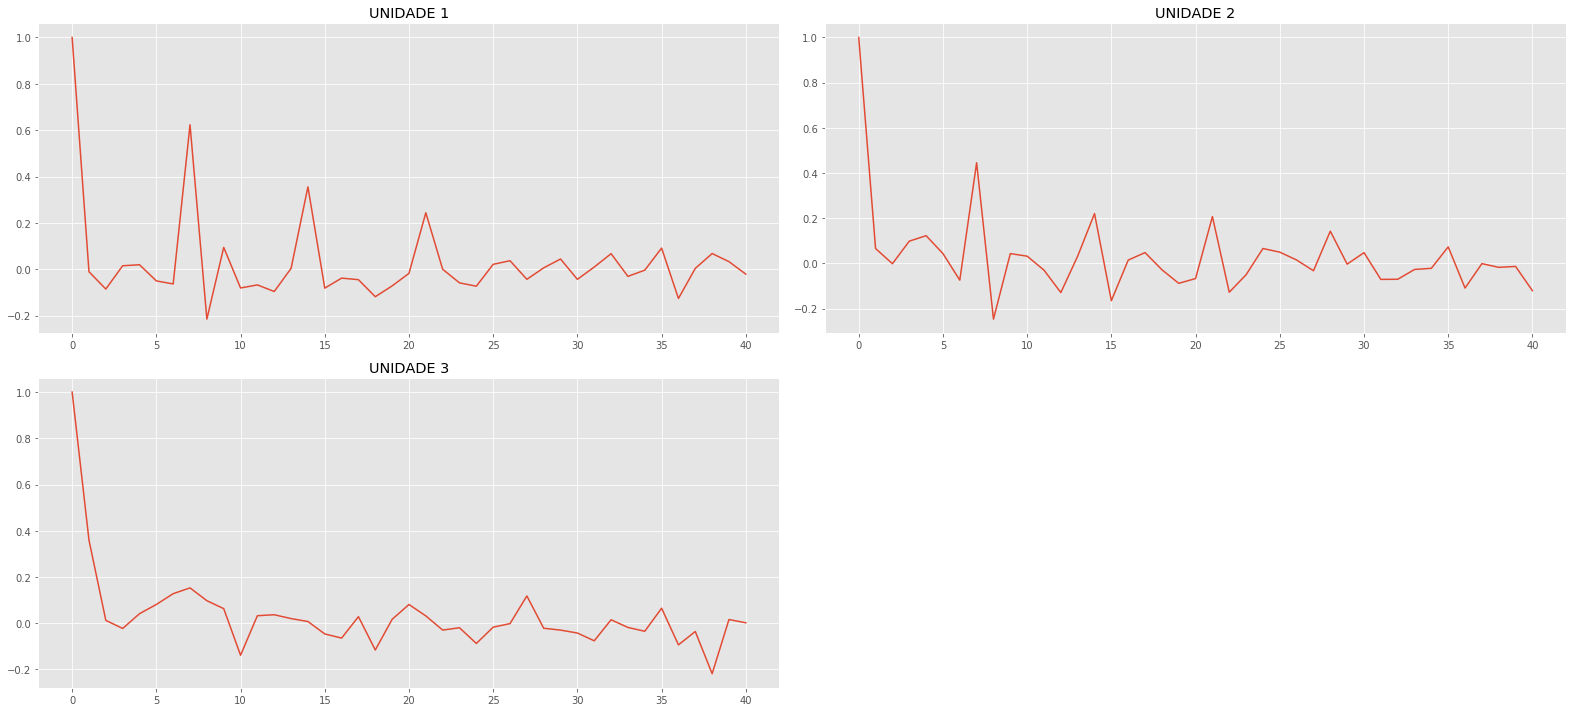

In [9]:
plt.figure(1, figsize=(22, 10))
for i in range(3):
    plt.subplot(2,2,i+1)
    pacf_x = pacf(vendas_log[vendas_log.columns[i]])
    plt.plot(pacf_x)
    plt.title(vendas_log.columns[i])

plt.tight_layout()

# Iniciando o modelo.

* Para tentarmos modelar os dados diários usaremos o modelo de auto regressão integrado com médias móveis (ARIMA)
* Tentaremos rodar o modelo com uma série parâmetros diferentes para encontrar o que gera o menor MAPE (média dos erros em %) possível.
* Por questões de processamento da miha pobre máquina, farei apenas em 1 unidade e tomarei como igual para as outras duas (não acho que é o melhor caminho, mas preservarei a ideia...)
* Geraremos o modelo e o compararemos com os dados observados para detectar se ele modela bem o que já passou...
* Modelo em azul.

In [13]:
def mape(y_true, y_pred): # Mean Absolute percentage error
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

p = d = q = range(0, 8)
pdq = list(itertools.product(p,d,q))
mape_ts = 10
order = []

for param in pdq:
    try:
        model_teste = ARIMA(vendas_log[vendas_log.columns[1]], order=param, freq ='D')
        h = model_teste.fit()
        x = mape(vendas_log[vendas_log.columns[1]].values,h.fittedvalues)
        
        if x < mape_ts:
            mape_ts = x
            order = param
    except:
        continue

In [16]:
print("O parâmetro -pdq- {}, obteve o menor MAPE de {}.".format(order, mape_ts))

O parâmetro -pdq- (7, 0, 6), obteve o menor MAPE de 1.7497150564370196.


,UNIDADE 1,UNIDADE 2,UNIDADE 3
Mape %,2.219056,1.749715,1.381577


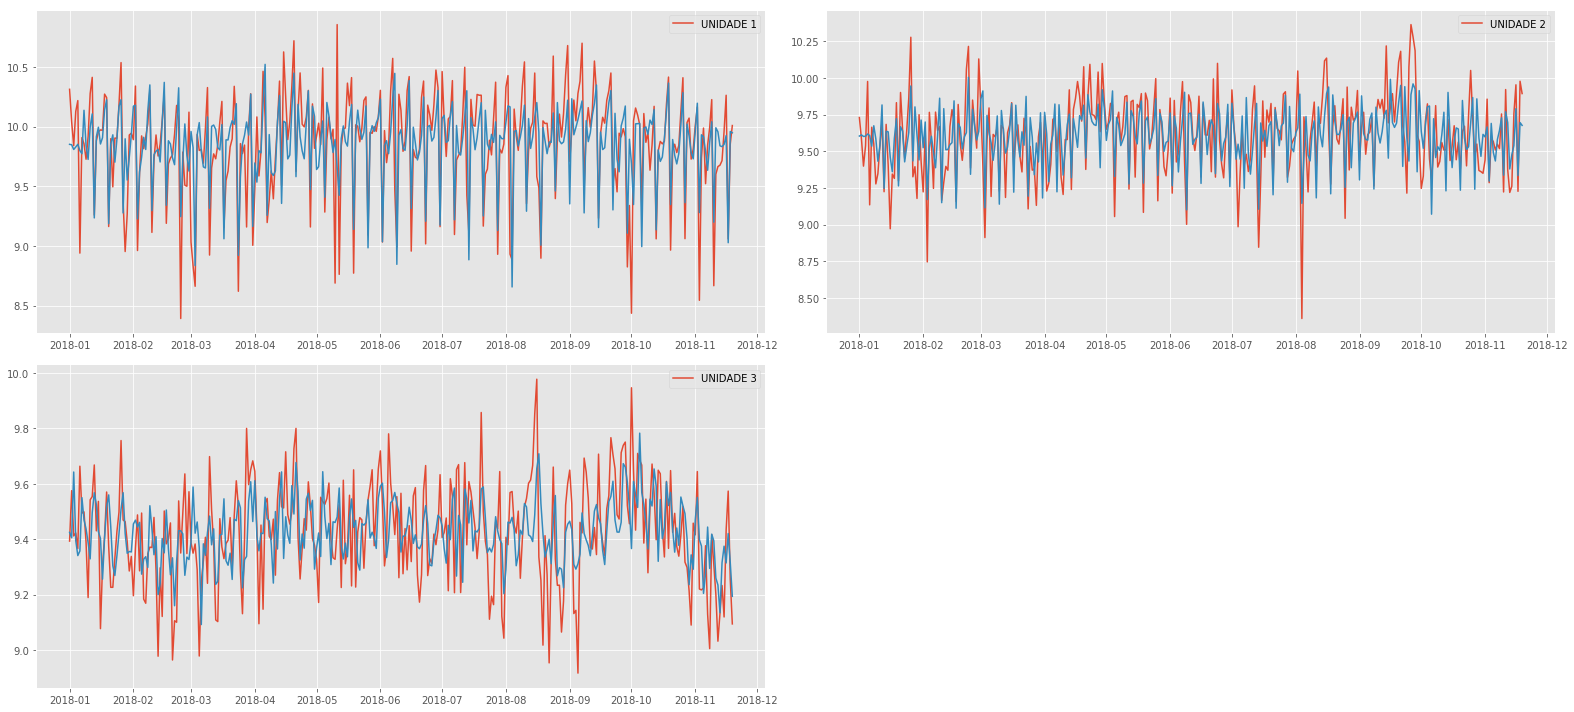

In [17]:
diagnostico = []

df_mape = pd.DataFrame(index=['Mape %'], columns=vendas.columns)

plt.figure(1, figsize=(22, 10))

for i in range(3):
    plt.subplot(2,2,i+1)
    model = ARIMA(vendas_log[vendas_log.columns[i]], order=(7,0,6), freq ='D')
    h = model.fit()
    
    df_mape[vendas_log.columns[i]] = mape(vendas_log[vendas_log.columns[i]].values,h.fittedvalues)
    
    plt.plot(vendas_log[vendas_log.columns[i]])
    plt.plot(h.fittedvalues)    
    plt.legend()
    
    diagnostico.append(h)    
plt.tight_layout()

df_mape

### Análise visual do modelo ajustado

Visualmente é complica dizer se o modelo é bom.
Para ajudar temos o MAPE, que diz para nós quanto é a média dos erros em %. Parece que ficou legal... 2% de erro...
Temos que tomar cuidado para isso não ser um overfitting (-Preciso estudar mais isso-) e chegarmos à conclusões erradas, mas não é o objetivo aqui. Apenas quero trazer a ideia de modelagem de séries temporais, que apesar de parecer fácil, é um campo muito amplo e complexo. E eu não sou referência no assunto #ainda =D#. 

PS.: Não recomendo usar com ações. Pode parecer tentador, ainda mais com modelos como o auto arima do R, onde ele te dá os melhores (p,d,q)... Vai por mim, não é legal. Em ações os movimentos não são dependentes apenas do tempo, preço de ontem não dita o preço de hoje/amanhã. No mercado as coisas estão muito mais voltadas para os movimentos Brownianos (um Q de aleatoriedade). 

Além de olhar apenas o MAPE, podemos ter uma noção se os erros ocorrem em uma distribuição normal de média 0.

In [18]:
df_mape.head()

,UNIDADE 1,UNIDADE 2,UNIDADE 3
Mape %,2.219056,1.749715,1.381577


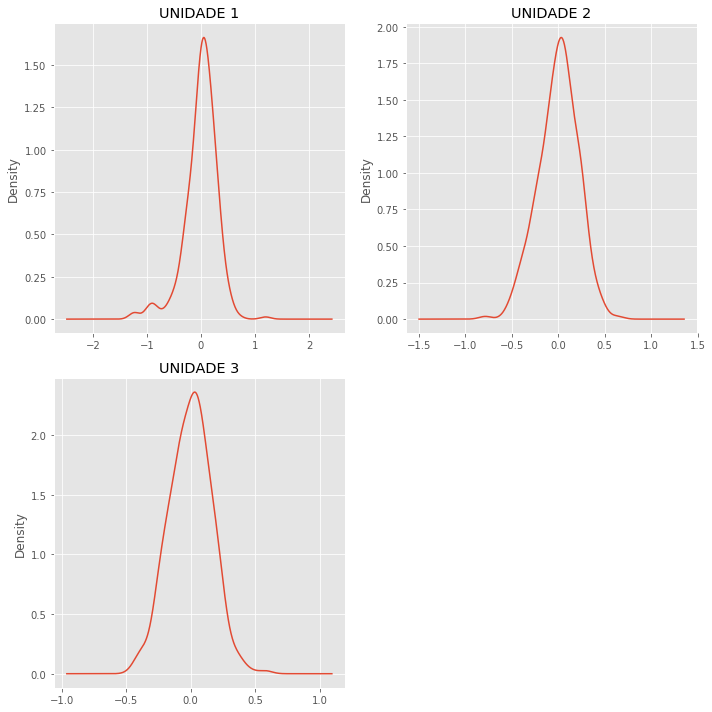

In [19]:
plt.figure(1, figsize=(10, 10))

for i in range(3):
    plt.subplot(2,2,i+1)
    diagnostico[i].resid.plot.kde()
    plt.title(vendas_log.columns[i])

plt.tight_layout()
    

### LEGAL!
Parece que tudo indica que podemos usar este modelo para tentarmos identificar o que acontecerá no resto do ano.
Mas é importante lembrar, futuro é sempre incerto! Não adianta buscar a asa esquerda da mosca. Vai dar ruim.

Vamos trabalhar entre intervalos de confiança, mais seguro! Lembrando que quanto mais o tempo se passa menor minha confiança (maior o intervalo).

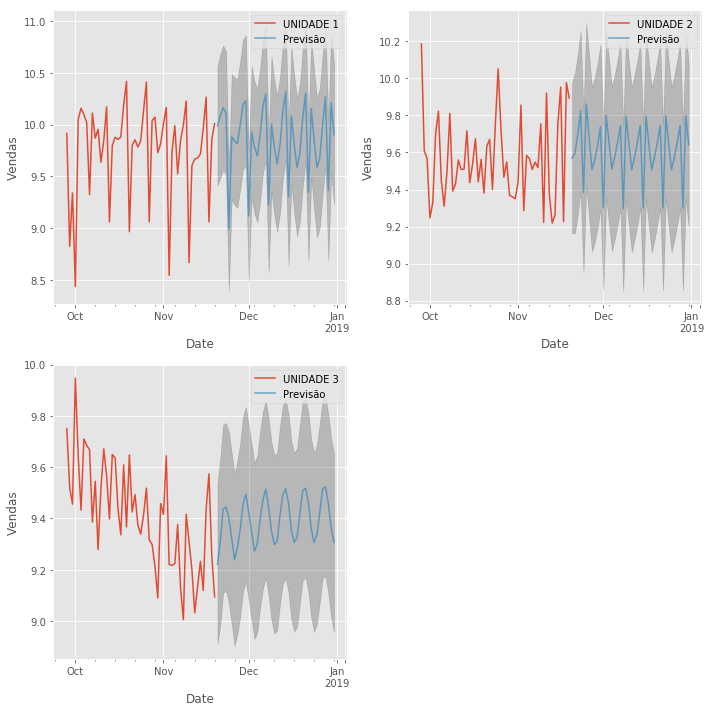

In [26]:
out = []

plt.figure(1, figsize=(10, 10))

for i in range(3):
    plt.subplot(2,2,i+1)
    pred = diagnostico[i].forecast(steps=42)
    
    pred_ci = pd.DataFrame(pred[2], # Intervalo de confiança
                           index=pd.DatetimeIndex(start='2018/11/20', end='2018/12/31', freq='D'))
                           
    prev_c = pd.DataFrame(index=pd.DatetimeIndex(start='2018/11/20', end='2018/12/31', freq='D'),
                          data=pred[0],
                          columns=["Previsão"])
    
    ax = vendas_log[vendas_log.columns[i]][270:].plot()
    prev_c.plot(ax=ax, alpha=0.7)
    
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:,0],
                    pred_ci.iloc[:,1], color='k', alpha=0.2)
    
    if i==0:
        out = prev_c
    else:
        out = pd.concat([out, prev_c],axis=1, sort=False)
    
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Vendas')
    plt.legend(loc='best')
    
plt.tight_layout()

Usei a média do intervalo de confiança para preencher a tabela, apenas para consolidar o resultado.

Apenas lembrando, sou um estudante de atuária que quer melhorar seu nível de código e conhecimento. Se você encontrou esse link e quer fazer algo parecido no seu trabalho, cuidado... Consulte sempre um profissional =D

Agradeceria demais um feedback, seja em nível de código ou conteúdo (até em português...). 
Vai me ajudar muito saber onde tenho que melhorar/refazer/estudar.
Aprender by yourself tem seus problemas: Você não sabe se está realmente certo, ou até no caminho certo.

Muito obrigado!! =D

In [23]:
final = pd.concat([vendas_log, out],axis=0, sort=False)
final = np.exp(final)

final.resample('M').sum().round()

,UNIDADE 1,UNIDADE 2,UNIDADE 3
2018-01-31,640089.0,442859.0,389606.0
2018-02-28,523978.0,422174.0,320728.0
2018-03-31,532144.0,423930.0,379770.0
2018-04-30,678814.0,498956.0,394152.0
2018-05-31,677067.0,490445.0,397217.0
2018-06-30,660068.0,460193.0,382969.0
2018-07-31,651487.0,453627.0,389563.0
2018-08-31,703841.0,497680.0,393468.0
2018-09-30,682150.0,555043.0,406439.0
2018-10-31,611253.0,436934.0,414853.0
